In [1]:
import cv2
import numpy as np
import os
from gtts import gTTS
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import playsound


from tensorflow.keras.layers import Input

from src.yolo3.model import *
from src.yolo3.detect import *

from src.utils.image import *
from src.utils.datagen import *
from src.utils.fixes import *

fix_tf_gpu()

playsound is relying on a python 2 subprocess. Please use `pip3 install PyObjC` if you want playsound to run more efficiently.


## **Helper functions**

In [2]:
def prepare_model(approach):
    '''
    Prepare the YOLO model
    '''
    global input_shape, class_names, anchor_boxes, num_classes, num_anchors, model

    # shape (height, width) of the imput image
    input_shape = (416, 416)

    # class names
    if approach == 1: #헬맷, 조끼, 워커
        class_names = ['H', 'V', 'W']

    elif approach == 2: # 워커, 헬맷 쓴 워커, 조끼 입은 워커, 둘다 입은 워커
        class_names  = ['W','WH','WV','WHV']

    elif approach == 3: #워커인지 아닌지
        class_names  = ['W']

    else:
        raise NotImplementedError('Approach should be 1, 2, or 3')

    # anchor boxes
    if approach == 1:
        anchor_boxes = np.array(
            [
            np.array([[ 76,  59], [ 84, 136], [188, 225]]) /32, # output-1 anchor boxes
            np.array([[ 25,  15], [ 46,  29], [ 27,  56]]) /16, # output-2 anchor boxes
            np.array([[ 5,    3], [ 10,   8], [ 12,  26]]) /8   # output-3 anchor boxes
            ],
            dtype='float64'
        )
    else:
        anchor_boxes = np.array(
            [
            np.array([[ 73, 158], [128, 209], [224, 246]]) /32, # output-1 anchor boxes
            np.array([[ 32,  50], [ 40, 104], [ 76,  73]]) /16, # output-2 anchor boxes
            np.array([[ 6,   11], [ 11,  23], [ 19,  36]]) /8   # output-3 anchor boxes
            ],
            dtype='float64'
        )

    # number of classes and number of anchors
    num_classes = len(class_names)
    num_anchors = anchor_boxes.shape[0] * anchor_boxes.shape[1]

    # input and output
    input_tensor = Input( shape=(input_shape[0], input_shape[1], 3) ) # input
    num_out_filters = ( num_anchors//3 ) * ( 5 + num_classes )        # output

    # build the model
    model = yolo_body(input_tensor, num_out_filters)

    # load weights
    weight_path = f'./pictor-ppe-v302-a{approach}-yolo-v3-weights.h5' #가중치 불러와서
    model.load_weights( weight_path )

In [3]:
def get_detection(img):
    # save a copy of the img
    act_img = img.copy()

    # shape of the image
    ih, iw = act_img.shape[:2]

    # preprocess the image
    img = letterbox_image(img, input_shape)
    img = np.expand_dims(img, 0)
    image_data = np.array(img) / 255.

    # raw prediction from yolo model
    prediction = model.predict(image_data)

    # process the raw prediction to get the bounding boxes
    boxes = detection(
        prediction,
        anchor_boxes,
        num_classes,
        image_shape = (ih, iw),
        input_shape = (416,416),
        max_boxes = 10,
        score_threshold=0.3,
        iou_threshold=0.45,
        classes_can_overlap=False)

    # convert tensor to numpy
    boxes = boxes[0].numpy()

    # draw the detection on the actual image
    return draw_detection(act_img, boxes, class_names), boxes 

In [4]:
def plt_imshow(img):
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')

In [5]:
def check_box(box):
    l, t, r, b = box[:4]
    i = 1
    if abs(r-l)/ abs(b-t) < 0.1: #나눈 값이 1 : 9비율보다 크게 가로가 세로 9배이상
        i = -1
    return i

In [6]:
def reading_from_user(input_text, index):
    language = 'ko'
    slow_audio_speed = False
    filename = f"output_{index}.mp3"
    audio_created =gTTS(text=input_text, lang=language, slow=slow_audio_speed)
    audio_created.save(filename)

    os.system(f'start {filename}') #실행까지

In [7]:
# prepare the model
import time
start = time.time()
prepare_model(approach=3)

for i in range(1):
    # read the image
    img = cv2.imread( f'extras/sample-images/{i}.JPG' )
    # resize
    img = letterbox_image(img, input_shape) #레터박스

    # get the detection on the image
    tmp, boxes = get_detection(img) #디텍션 
    
    fin_boxes = []
    for box in boxes:
        #print(check_box(box))
        if check_box(box) == 1:
            fin_boxes.append(box)
    # show the image
    plt_imshow(img[:, :, ::-1])
    
    ##
    tmp_2 = []
    images_2 = []
    img_2 = []
    for index, i in enumerate(fin_boxes):
        #print(index)
        left, top, right, bottom, accuracy, classes = i
        #print(left, top, right, bottom, accuracy, classes)
        
        if top < 10:
            top = 10
        if bottom > 405:
            bottom = 405
        if left < 10:
            left = 10
        if right > 405:
            rigt = 405

        tmp_2.append(img[int(top)-10:int(bottom)+10, int(left)-10:int(right)+10])
        #plt.imshow(cv2.cvtColor(tmp_2[index], cv2.COLOR_BGR2RGB))

        #cv2.imwrite(f'worker {index}.jpg', tmp_2[index])
        
        # prepare the model
        prepare_model(approach=1)

        # resize
        images_2.append(letterbox_image(tmp_2[index], input_shape))

        # get the detection on the image
        imgss, boxes_2 = get_detection(images_2[index])
        fin_boxes_2 = []
        for box in boxes_2:
            if check_box(box) == 1:
                if box[5] < 2: #워커가 아닐때
                    fin_boxes_2.append(box)
        img_2.append(imgss)
        # show the image
        now = images_2[index]
        plt_imshow(now[:, :, ::-1])
        tmp_3 = []
        images_3 = []
        img_3 = []
        
        answer = 0
        for index, i in enumerate(fin_boxes_2):
            #print(index)
            left, top, right, bottom, accuracy, classes = i
            #print(left, top, right, bottom, accuracy, classes)

            if top < 10:
                top = 10
            if bottom > 405:
                bottom = 405
            if left < 10:
                left = 10
            if right > 405:
                rigt = 405

            tmp_3.append(now[int(top)-10:int(bottom)+10, int(left)-10:int(right)+10])
            #plt.imshow(cv2.cvtColor(tmp_2[index], cv2.COLOR_BGR2RGB))

            #cv2.imwrite(f'worker {index}.jpg', tmp_2[index])

            # prepare the model
            prepare_model(approach=1)

            # resize
            images_3.append(letterbox_image(tmp_3[index], input_shape))

            # get the detection on the image
            imgss, boxes_3 = get_detection(images_3[index])
            #fin_boxes_3 = []
            #for box in boxes_2:
            #    if check_box(box) == 1:
            #        fin_boxes_2.append(box)
            img_3.append(imgss)
            # show the image
            if classes == 0:
                print('안전모를 착용하였습니다!')
                answer += 1
            elif classes == 1:
                print('안전 조끼를 착용하였습니다!')
                answer += 2
            plt_imshow(images_3[index][:, :, ::-1])
            nows = time.time()
            nows  = nows - start
            print(f'현재 {nows}')
        if answer == 3:
            now_answer = '안전한 상태입니다.'
        elif answer == 2:
            now_answer = '주의하셔야 합니다.'
        else:
            now_answer = '위험합니다! 안전 장비를 착용하십시오'
        print('------------------------')
        reading_from_user(now_answer, index)
        #playsound.playsound(f'./output_{index}.mp3')


if __name__ == '__main__':
    reading_from_user()
end = time.time()
print(end - start)

Metal device set to: Apple M1


2021-12-08 11:20:17.483157: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-08 11:20:17.484208: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


OSError: Unable to open file (unable to open file: name = './pictor-ppe-v302-a3-yolo-v3-weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
import grob

In [ ]:
grob.grob

In [ ]:
# 명수당 8초

In [27]:
import torch 

USE_CUDA = torch.cuda.is_available() 
print(USE_CUDA)
device = torch.device('cuda:0' if USE_CUDA else 'cpu') 
print('학습을 진행하는 기기:',device)

True
학습을 진행하는 기기: cuda:0


In [ ]:
time.time()

In [36]:
fin_boxes_2

[]

In [ ]:
len(images)

In [ ]:
fin_boxes_2

In [ ]:
fin_boxes_2

In [ ]:
plt_imshow(imgss[0][:, :, ::-1])

In [65]:
len(imgss)

416

In [66]:
len(imgs)

1

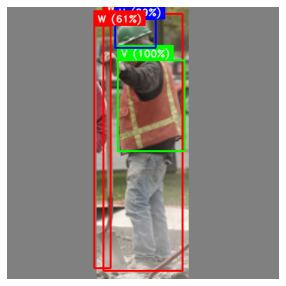

In [87]:
plt_imshow(imgs[0][:, :, ::-1])

In [88]:
boxes_2

array([[147.03656   ,  10.663086  , 268.11844   , 403.41943   ,
          0.9999331 ,   2.        ],
       [169.00471   ,  81.759514  , 271.6382    , 220.05106   ,
          0.9996804 ,   1.        ],
       [165.17197   ,  18.425371  , 227.66507   ,  62.389587  ,
          0.8905389 ,   0.        ],
       [133.08769   ,  28.660477  , 158.40916   , 399.16626   ,
          0.60810536,   2.        ]], dtype=float32)

In [99]:
l, t, r, b = boxes_2[3][:4]

if abs(r-l)/ abs(b-t) > 30:
    continue

0.06834298

In [39]:
import GTTS

ModuleNotFoundError: No module named 'GTTS'

In [50]:
import os 
from gtts import gTTS

SyntaxError: invalid syntax (1189418006.py, line 1)

In [40]:
text_to_read = "안녕"
language = 'ko'
slow_audio_speed = False
filename = "my_file.mp3"

def reading_from_user():
    user_input = input("뭐라할까?\n")
    audio_created =gTTS(text=user_input, lang=language, slow=slow_audio_speed)
    audio_created.save(filename)

    os.system(f'start {filename}')


if __name__ == '__main__':
    reading_from_user()

뭐라할까?
say


NameError: name 'gTTS' is not defined

In [51]:
pip install gTTS

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
